# Using Decision Tree Classifiers in `scikit-learn`

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# for data preprocessing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
# for building and visualizing the decision tree
from sklearn.tree import DecisionTreeClassifier
# visualization
from vis_tree import visualize_tree
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
plt.matplotlib.rcParams["hatch.color"] = [0.7]*3

imported pydotplus


In [2]:
## the original source (for reference)
# ! wget https://github.com/rudeboybert/JSE_OkCupid/raw/master/profiles.csv.zip -O data/profiles.csv.zip
# ! unzip data/profiles.csv.zip -d data

## Load the data

In [3]:
# load
data = pd.read_csv("data/ok_cupid_norm.csv",).dropna()
print("dimensions of the table:", data.shape)

# separate a validation set
pd.np.random.seed(3)
data = shuffle(data)
validation = data[:100]
data = data[100:]

# inspect the header
data.head()

dimensions of the table: (12254, 22)


,age,orientation,sex,religion,height,smokes,ethnicity,education,income,bodytype,...,drugs,adventur,fun,chill,outdoor,music,cook,dietmode,dogs,cats
27529,38,straight,m,other,69.0,no,"asian, indian",graduated from masters program,-1,fit,...,never,False,False,True,False,False,True,mostly,likes,likes
4721,19,straight,f,catholicism,71.0,no,"black, white",graduated from high school,-1,fit,...,sometimes,False,False,True,False,False,False,-,likes,dislikes
3776,28,straight,m,other,70.0,when drinking,indian,graduated from college/university,30000,athletic,...,sometimes,False,True,False,False,True,True,-,likes,likes
26289,26,straight,m,agnosticism,70.0,no,white,graduated from masters program,100000,athletic,...,never,False,False,False,False,True,True,mostly,likes,likes
58807,27,straight,m,catholicism,66.0,no,asian,graduated from masters program,30000,curvy,...,never,True,False,False,False,True,False,-,likes,likes


In [4]:
data.columns

Index(['age', 'orientation', 'sex', 'religion', 'height', 'smokes',
       'ethnicity', 'education', 'income', 'bodytype', 'sign', 'diet', 'drugs',
       'adventur', 'fun', 'chill', 'outdoor', 'music', 'cook', 'dietmode',
       'dogs', 'cats'],
      dtype='object')

In [5]:
data["drugs"].unique()

array(['never', 'sometimes', 'often'], dtype=object)

In [6]:
target_col = "drugs"
feature_cols = [col for col in data.columns if col != target_col]

In [7]:
features = data[feature_cols]
mask_missing = features.isnull().any(axis=1)

# to simplify task, let us look for any drug use:
target = data[target_col]!="never"

## Convert categorical features into one-hot encoding

In [8]:
features_onehot = pd.get_dummies(features, drop_first=True)
features_onehot.head()

,age,height,income,adventur,fun,chill,outdoor,music,cook,orientation_gay,...,diet_other,diet_unknown,diet_vegan,diet_vegetarian,dietmode_mostly,dietmode_strictly,dogs_has,dogs_likes,cats_has,cats_likes
27529,38,69.0,-1,False,False,True,False,False,True,0,...,0,0,0,0,1,0,0,1,0,1
4721,19,71.0,-1,False,False,True,False,False,False,0,...,0,1,0,0,0,0,0,1,0,0
3776,28,70.0,30000,False,True,False,False,True,True,0,...,0,0,0,0,0,0,0,1,0,1
26289,26,70.0,100000,False,False,False,False,True,True,0,...,0,0,0,0,1,0,0,1,0,1
58807,27,66.0,30000,True,False,False,False,True,False,0,...,0,0,0,0,0,0,0,1,0,1


In [9]:
# this is needed for visualization purposes:
flag_cols = features.columns[features.dropna().dtypes.map(lambda x: x in (pd.np.dtype('O'), bool))].tolist()

## Create an instance of `DecisionTreeClassifier` class

In [14]:
dtree = DecisionTreeClassifier(max_depth=3, min_samples_leaf=100, criterion="entropy")

## Fit the classifier

In [15]:
dtree.fit(features_onehot, target)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=100,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Visualize the tree

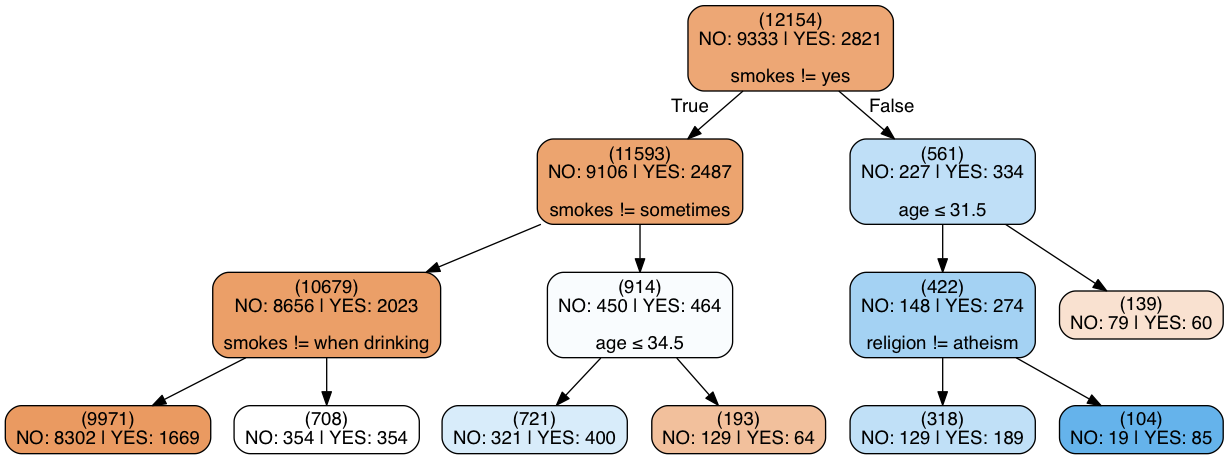

In [16]:
visualize_tree(dtree, feature_names=features_onehot.columns, flag_cols=flag_cols, class_names=["NO","YES"])

## [Task:] Use the `dtree` classifier object to predict target in the `validation` table

+ Which preprocessing steps are required?

+ Calculate precision and recall
```
recall = TP / (TP + FN)      # out of all truly positive
precision = TP / (TP + FP)   # out of all classified as positive
```

## [Task:] Increase the depth of the tree to 7. 

+ Visualize the obtained trees
+ How does performance in `validation` set change?
+ Which features appear in the tree nodes? which don't?

## Visualization with mosaic plots:

drugs
drug +    -0.225495
drug -    -0.441900
dtype: float64


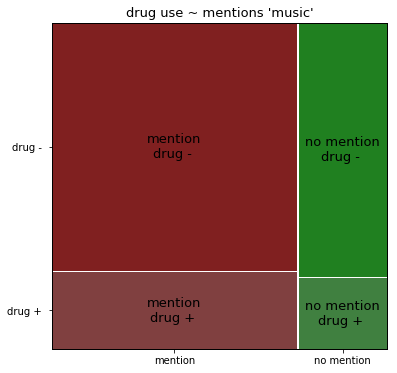

In [17]:
contig = pd.crosstab((data["drugs"]!="never").map(lambda x: "drug + " if x else "drug - "),
#                    data["dogs"].map(lambda x: "has dogs" if x in ("likes", "dislikes") else "no dogs"), 
                     data["music"].map(lambda x: "mention" if x  else "no mention"), 
                   ).T

entropy = ((contig.T/contig.sum(1)).applymap(lambda x: x*np.log2(x)).sum(1) * contig.sum(0)) / contig.sum().sum()
print(entropy)

contig = contig.stack()

fig,ax = plt.subplots(1, figsize=(6,6))
fig, _ = mosaic(contig, ax=ax, axes_label=True, 
#                 labelizer=labelizer,
#                 properties=properties,
               )
fontsize = 13
ax.set_title("drug use ~ mentions 'music'", fontsize=20)
texts = [obj for obj in ax.get_children() if type(obj) is plt.matplotlib.text.Text]
[txt.set_fontsize(fontsize) for txt in texts]
# fig.savefig("img/drugs_music.png", dpi=300, format='png')
pass

## Extract tree structure and information by hand 

In [18]:
def get_branches(tr, nid=0, feat_names = None, prefix=""):
    print("{}{} {}".format( prefix, tr.value[nid][0],  tr.impurity[nid]))
    if tr.feature[nid] == -2:
        print(prefix + "---")
        pass
    else:
        feat_name = features_onehot.columns[tr.feature[nid]]
        print(prefix + "{} = True:".format(feat_name))
        get_branches(tr, nid=tr.children_right[nid], prefix=prefix + "|  ")
        print(prefix + "{} = False:".format(feat_name))
        get_branches(tr, nid=tr.children_left[nid], prefix=prefix + "|  ")
        
#     [(features_onehot.columns[tr.feature[nid]], tr.threshold[nid], ) for nid in range(len(tr.feature)) if tr.feature[nid]>=0]

In [21]:
get_branches(dtree.tree_)

[ 9333.  2821.] 0.7816621894357266
smokes_yes = True:
|  [ 227.  334.] 0.9735971739753327
|  age = True:
|  |  [ 79.  60.] 0.986479814863779
|  |  ---
|  age = False:
|  |  [ 148.  274.] 0.9347013478439887
|  |  religion_atheism = True:
|  |  |  [ 19.  85.] 0.6859315226878925
|  |  |  ---
|  |  religion_atheism = False:
|  |  |  [ 129.  189.] 0.9741655523680581
|  |  |  ---
smokes_yes = False:
|  [ 9106.  2487.] 0.7500454313541237
|  smokes_sometimes = True:
|  |  [ 450.  464.] 0.9998307513525335
|  |  age = True:
|  |  |  [ 129.   64.] 0.9165590271665272
|  |  |  ---
|  |  age = False:
|  |  |  [ 321.  400.] 0.9913223822836115
|  |  |  ---
|  smokes_sometimes = False:
|  |  [ 8656.  2023.] 0.7002926678968382
|  |  smokes_when drinking = True:
|  |  |  [ 354.  354.] 1.0
|  |  |  ---
|  |  smokes_when drinking = False:
|  |  |  [ 8302.  1669.] 0.6516886298884014
|  |  |  ---
